<a href="https://colab.research.google.com/github/EAsencios/DEEP-LEARING/blob/master/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup
!pip install -U tensorflow_addons

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

### Preparate the data

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

print('X_train shape: {} - y_train shape: {}'.format(X_train.shape, y_train.shape))
print("X_test shape: {} - y_test shape: {}".format(X_test.shape, y_train.shape))

169017344/169001437 [==============================] - 2s 0us/step
X_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3) - y_test shape: (50000, 1)


### Configure the hyperparameters

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72   # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extraxt from the input images
num_patches = (image_size // patch_size)**2
projection_dim = 64
num_heads = 4
transformer_units = [
                     projection_dim*2,
                     projection_dim,
]   # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] # Size of the dense layers of the final classifier

### Use data augmentation

In [6]:
from sys import hexversion
data_augmentation = keras.Sequential(
    [
     layers.Normalization(),
     layers.Resizing(image_size, image_size),
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(factor=0.02),
     layers.RandomZoom(height_factor=.2, width_factor=.2),
     ],
     name = "data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

### Implement multilayer perceptron

In [7]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

### Implement pach creation as a layer

In [8]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
      super(Patches, self).__init__()
      self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(images=images,
                                       sizes=[1, self.patch_size, self.patch_size, 1],
                                       strides=[1, self.patch_size, self.patch_size, 1],
                                       rates=[1, 1, 1, 1],
                                       padding="VALID",
                                       )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


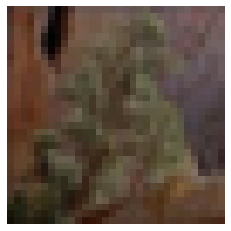

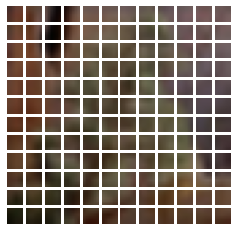

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i + 1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis("off")